## 1. Settings

## 1.1 Setting up the environment

In [314]:
import torch
from tbmalt import Geometry, OrbitalInfo
from tbmalt.physics.dftb import Dftb2
from tbmalt.physics.dftb.feeds import SkFeed, SkfOccupationFeed, HubbardFeed, RepulsiveSplineFeed
from tbmalt.common.maths.interpolation import CubicSpline
from tbmalt.ml.loss_function import Loss, mse_loss
import torch.nn as nn

from ase.build import molecule

Tensor = torch.Tensor

# This must be set until typecasting from HDF5 databases has been implemented.
torch.set_default_dtype(torch.float64)

## 1.2 Setting up the molecular systems for training

In [315]:
# Provide a list of moecules for training
molecule_names = ['H2O']

# Reference of target properties
targets = {'total_energy': torch.tensor(-4.0779379326)}

# Provide information about the orbitals on each atom; this is keyed by atomic
# numbers and valued by azimuthal quantum numbers like so:
#   {Z₁: [ℓᵢ, ℓⱼ, ..., ℓₙ], Z₂: [ℓᵢ, ℓⱼ, ..., ℓₙ], ...}
shell_dict = {1: [0], 6: [0, 1], 7: [0, 1], 8: [0, 1]}

## 1.3 Setting up the model for training

In [316]:
# Before running this example, please use setup.ipynb to download the parameter set needed
# Location at which the DFTB parameter set database is located
parameter_db_path = 'mio.h5'

# Type of ML model
model = 'spline'

# Whether performing model fitting
fit_model = True

# Number of training cycles
number_of_epochs = 75

# Learning rate
lr = 0.002

# Loss function
loss_func = mse_loss

## 1.4 Setting up the DFTB calculator

## 1.4.1 Input the molecular systems

In [317]:
device = torch.device('cpu')
# Construct the `Geometry` and `OrbitalInfo` objects. The former is analogous
# to the ase.Atoms object while the latter provides information about what
# orbitals are present and which atoms they belong to.
geometry = Geometry(
        torch.tensor([8,1,1], device=device),
        torch.tensor([
            [0.00000000, -0.71603315, -0.00000000],
            [0.00000000, -0.14200298, 0.77844804 ],
            [-0.00000000, -0.14200298, -0.77844804]],
            device=device),units='a')

orbs = OrbitalInfo(geometry.atomic_numbers, shell_dict)

print('Geometry:', geometry)
print('OrbitalInfo:', orbs)

# Identify which species are present
species = torch.unique(geometry.atomic_numbers)
# Strip out padding species and convert to a standard list.
species = species[species != 0].tolist()

Geometry: Geometry(OH2)
OrbitalInfo: <tbmalt.structures.orbitalinfo.OrbitalInfo object at 0x7fbc50c22dd0>


## 1.4.2 Loading of the DFTB parameters into their associated feed objects

In [318]:
# Load the Hamiltonian feed model
h_feed = SkFeed.from_database(parameter_db_path, species, 'hamiltonian',
                              interpolation=CubicSpline, requires_grad_onsite=True, requires_grad_offsite=True)

# Load the overlap feed model
s_feed = SkFeed.from_database(parameter_db_path, species, 'overlap',
                              interpolation=CubicSpline)

# Load the occupation feed object
o_feed = SkfOccupationFeed.from_database(parameter_db_path, species)

# Load the Hubbard-U feed object
u_feed = HubbardFeed.from_database(parameter_db_path, species)

#When add r_feed, loss: tensor(1.4389e-09) on epoch 0
#r_feed = RepulsiveSplineFeed.from_database(parameter_db_path, species)

## 1.4.3 Constructing the SCC-DFTB calculator

In [ ]:
dftb_calculator = Dftb2(h_feed, s_feed, o_feed, u_feed, filling_scheme=None)

zero_tensor = nn.Parameter(torch.rand((6, 6), dtype=torch.double))

def return_random_tensor(geometry, orbs):
    return zero_tensor

# Methode ersetzen
h_feed.matrix = return_random_tensor

# Test
H = h_feed.matrix(geometry, orbs)
print('H:', H)

H: Parameter containing:
tensor([[0.1294, 0.3944, 0.9115, 0.3050, 0.3288, 0.8858],
        [0.4391, 0.3988, 0.9558, 0.8930, 0.2673, 0.3242],
        [0.0765, 0.6723, 0.3761, 0.1178, 0.2099, 0.3327],
        [0.1450, 0.4118, 0.1081, 0.7565, 0.3600, 0.0976],
        [0.4255, 0.7476, 0.0302, 0.2104, 0.7348, 0.5833],
        [0.0805, 0.0838, 0.4195, 0.1342, 0.1239, 0.4830]], requires_grad=True)


## 2. Data preparation

In [320]:
# Define a delegate to obtain predictions from the trained model
def prediction_delegate(calculator, targets, **kwargs):
     predictions = dict()
     predictions["energy"] = calculator.total_energy
     
     return predictions

In [321]:
# Define a delegate to obtain reference results
def reference_delegate(calculator, targets, **kwargs):
     references = dict()
     references["energy"] = targets['total_energy']

     return references

## 3. Model training

In [322]:
# Define parameters to optimize
variable = h_feed.matrix(geometry, orbs)
print(variable)

Parameter containing:
tensor([[0.1294, 0.3944, 0.9115, 0.3050, 0.3288, 0.8858],
        [0.4391, 0.3988, 0.9558, 0.8930, 0.2673, 0.3242],
        [0.0765, 0.6723, 0.3761, 0.1178, 0.2099, 0.3327],
        [0.1450, 0.4118, 0.1081, 0.7565, 0.3600, 0.0976],
        [0.4255, 0.7476, 0.0302, 0.2104, 0.7348, 0.5833],
        [0.0805, 0.0838, 0.4195, 0.1342, 0.1239, 0.4830]], requires_grad=True)


In [323]:
# Define the loss entity
loss_entity = Loss(prediction_delegate, reference_delegate,
                   loss_functions=loss_func, reduction='mean')

In [324]:
# Define optimizer
optimizer = torch.optim.Adam([variable], lr=lr)

In [325]:
# Execution
loss_list = []
loss_list.append(0)
for epoch in range(number_of_epochs):
    _loss = 0
    print('epoch', epoch)
    dftb_calculator(geometry, orbs, grad_mode="direct")
    total_loss, raw_losses = loss_entity(dftb_calculator, targets)
    _loss = _loss + total_loss
    optimizer.zero_grad()
    _loss.retain_grad()

    # Invoke the autograd engine
    _loss.backward(retain_graph=True)

    # Update the model
    optimizer.step()
    print("loss:", _loss)
    loss_list.append(_loss.detach())

epoch 0
loss: tensor(19.5933, grad_fn=<AddBackward0>)
epoch 1
loss: tensor(19.0903, grad_fn=<AddBackward0>)
epoch 2
loss: tensor(18.5947, grad_fn=<AddBackward0>)
epoch 3
loss: tensor(18.1065, grad_fn=<AddBackward0>)
epoch 4
loss: tensor(17.6258, grad_fn=<AddBackward0>)
epoch 5
loss: tensor(17.1527, grad_fn=<AddBackward0>)
epoch 6
loss: tensor(16.6872, grad_fn=<AddBackward0>)
epoch 7
loss: tensor(16.2294, grad_fn=<AddBackward0>)
epoch 8
loss: tensor(15.7793, grad_fn=<AddBackward0>)
epoch 9
loss: tensor(15.3370, grad_fn=<AddBackward0>)
epoch 10
loss: tensor(14.9023, grad_fn=<AddBackward0>)
epoch 11
loss: tensor(14.4755, grad_fn=<AddBackward0>)
epoch 12
loss: tensor(14.0564, grad_fn=<AddBackward0>)
epoch 13
loss: tensor(13.6451, grad_fn=<AddBackward0>)
epoch 14
loss: tensor(13.2416, grad_fn=<AddBackward0>)
epoch 15
loss: tensor(12.8459, grad_fn=<AddBackward0>)
epoch 16
loss: tensor(12.4579, grad_fn=<AddBackward0>)
epoch 17
loss: tensor(12.0777, grad_fn=<AddBackward0>)
epoch 18
loss: tenso

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

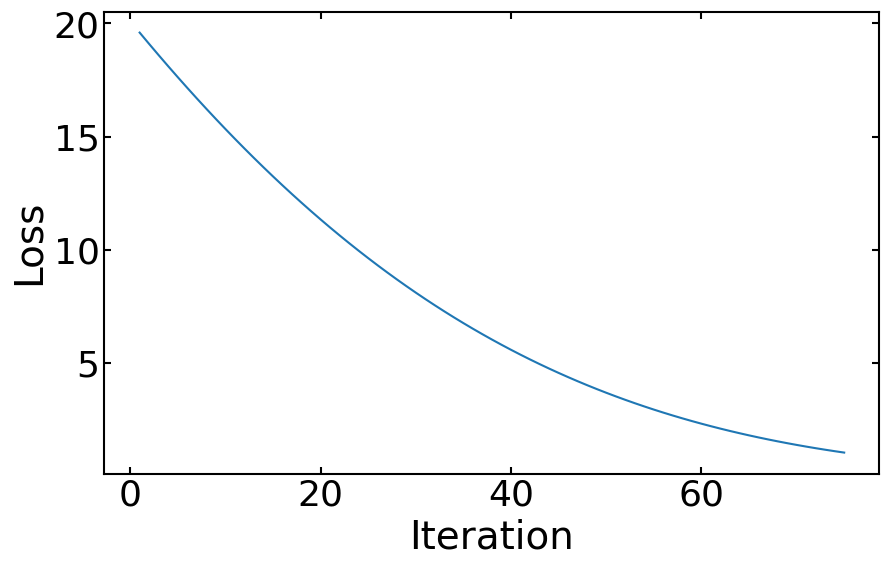

In [326]:
# Plot the loss
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.linewidth"] = 1.5
plt.tick_params(direction='in', labelsize='26', width=1.5, length=5, top='on',
                    right='on', zorder=10)
plt.plot(torch.linspace(1, number_of_epochs, number_of_epochs),
         loss_list[1:])
plt.xlabel("Iteration", fontsize=28)
plt.ylabel("Loss",  fontsize=28)
#plt.savefig('loss_hubbard.pdf', dpi=500, bbox_inches='tight')
plt.show()